## Wstępna Analiza Danych - MOW 2
### 2016 UK Road Safety: Traffic Accidents and Vehicles

Anastazja Kandratsiuk, Bartosz Bojarski

Opis zbioru:
Zbiór danych zawiera informacje o wszystkich wypadkach drogowych w Wielkiej Brytani z roku 2016. Dane zostały przygotowane przez Departament Transportu Wielkiej Brytanii i przez inicjatywę Open Gov. Oryginalne dane są podzielone na cztery pliki, które opisują parametry dotyczące ofiar, pojazdów, czy okoliczności wypadków. Zostały one połączone w dwa zbiory danych, jeden opisujący geolokację wypadków, a drugi zawierający wszystkie pozostałe informacje.  
Część kolumn jest przygotowana w formie kodów, które wymagają przetłumaczenia na zrozumiałe wartości. Będzie to robione przy pomocy słowników, które zostały dostarczone wraz z danymi, a sama translacja będzie wykonywana w trakcie analizy danych.



Import bibliotek

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from shapely.geometry import Point


Wczytanie danych

In [4]:
Casualties = pd.read_csv('dane/Cas.csv')
MakeModel = pd.read_csv('dane/MakeModel2016.csv')
Accidents = pd.read_csv('dane/dftRoadSafety_Accidents_2016.csv', low_memory=False)
Vehicles = pd.read_csv('dane/Veh.csv')

Rozbicie danych na dane geograficzne i pozostałe

In [5]:
Comp_data = pd.merge(Accidents, Casualties, on='Accident_Index')
Comp_data = pd.merge(Comp_data, Vehicles, on='Accident_Index')
Comp_data = pd.merge(Comp_data, MakeModel, on='Accident_Index')

Geo_data = pd.DataFrame(Comp_data, columns=['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude'])
Data_no_geo = Comp_data.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude'], axis=1)

### Prezentacja podstawowych danych zbioru danych

Zbiór danych posiada 92 kolumny i 804853 wiersze. Kluczem głównym dla zbioru danych jest kolumna 'Accident_Index'. 
Kolejne cztery kolumny zawierają informacje o geolokalizacji wypadków. Pozostałe kolumny zawierają informacje o wypadkach, ofiarach, pojazdach, czy okolicznościach wypadków.

In [6]:
Comp_data.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Journey_Purpose_of_Driver_y,Sex_of_Driver_y,Age_Band_of_Driver_y,Engine_Capacity_(CC)_y,Propulsion_Code_y,Age_of_Vehicle_y,Driver_IMD_Decile_y,Driver_Home_Area_Type_y,make,model
0,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,1,1,8,-1,-1,-1,3,1,NaN,NaN
1,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,6,1,5,124,1,4,4,1,YAMAHA,HW 125 XENTER
2,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,1,1,8,-1,-1,-1,3,1,NaN,NaN
3,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,6,1,5,124,1,4,4,1,YAMAHA,HW 125 XENTER
4,2016010000006,551920.0,174560.0,0.184928,51.449595,1,3,1,1,01/11/2016,...,6,2,7,1461,2,1,10,1,MERCEDES,A180 BLUEEFFICIENCY SPORT CDI


In [28]:
Data_no_geo.describe()

,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,...,1st_Point_of_Impact_y,Was_Vehicle_Left_Hand_Drive,Journey_Purpose_of_Driver_y,Sex_of_Driver_y,Age_Band_of_Driver_y,Engine_Capacity_(CC)_y,Propulsion_Code_y,Age_of_Vehicle_y,Driver_IMD_Decile_y,Driver_Home_Area_Type_y
count,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804679.000000,...,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000,804853.000000
mean,30.762009,2.801886,2.722990,2.197789,4.102374,354.275910,3.825053,881.748876,5.028114,41.791845,...,1.745326,0.999745,4.751142,1.417705,6.122138,1537.945788,1.051839,5.871495,3.698314,0.932550
std,24.362049,0.445092,1.434966,2.020741,1.933958,249.474336,1.502124,1710.898103,1.663407,15.799111,...,1.095624,0.129218,1.978891,0.611939,2.903485,1625.727781,1.290594,5.855146,3.665153,1.086339
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,20.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,10.000000,3.000000,2.000000,1.000000,2.000000,139.000000,3.000000,0.000000,3.000000,30.000000,...,1.000000,1.000000,3.000000,1.000000,5.000000,998.000000,1.000000,1.000000,-1.000000,1.000000
50%,32.000000,3.000000,2.000000,2.000000,4.000000,346.000000,3.000000,62.000000,6.000000,30.000000,...,1.000000,1.000000,6.000000,1.000000,7.000000,1498.000000,1.000000,5.000000,4.000000,1.000000
75%,46.000000,3.000000,3.000000,3.000000,6.000000,530.000000,6.000000,614.000000,6.000000,60.000000,...,2.000000,1.000000,6.000000,2.000000,8.000000,1968.000000,2.000000,10.000000,7.000000,1.000000
max,98.000000,3.000000,16.000000,58.000000,7.000000,941.000000,6.000000,9918.000000,9.000000,70.000000,...,4.000000,2.000000,6.000000,3.000000,11.000000,91000.000000,12.000000,75.000000,10.000000,3.000000


### Sprawdzenie brakujących danych

W zbiorze danych znajdują się brakujące dane w niektórych kolumnach. By spełnić wymagania projektu, będziemy dodawać brakujące dane w kolumnach, które będą analizowane, by osiągnąć poziom około 10% brakujących danych. W chwili obecnej najwięcej brakujących danych mamy w przypadku informacji o modelu auta (około 15% brakujących danych), a następnie informacje o jednostce geograficznej w której doszło do wypadku (około 5% brakujących danych). Jednak ta metoda sprawdzania wartości brakujących jest niewystarczająca, ponieważ w zakodowanych kolumnach wartość -1 oznacza brakujące dane.

In [10]:
Comp_data.isnull().sum()

Accident_Index                  0
Location_Easting_OSGR          50
Location_Northing_OSGR         50
Longitude                      50
Latitude                       50
                            ...  
Age_of_Vehicle_y                0
Driver_IMD_Decile_y             0
Driver_Home_Area_Type_y         0
make                       120749
model                      120749
Length: 92, dtype: int64

### Histogramy

Poniżej zaprezentowane są histogramy dla wybranych kolumn. Zaprezentowanie wszystkich histogramów w ramach jednego polecenia uniemożliwia wygodne odczytanie wartości z histogramów. Część z kolumn jest też zakodowana, więc nie ma sensu prezentować ich histogramów.

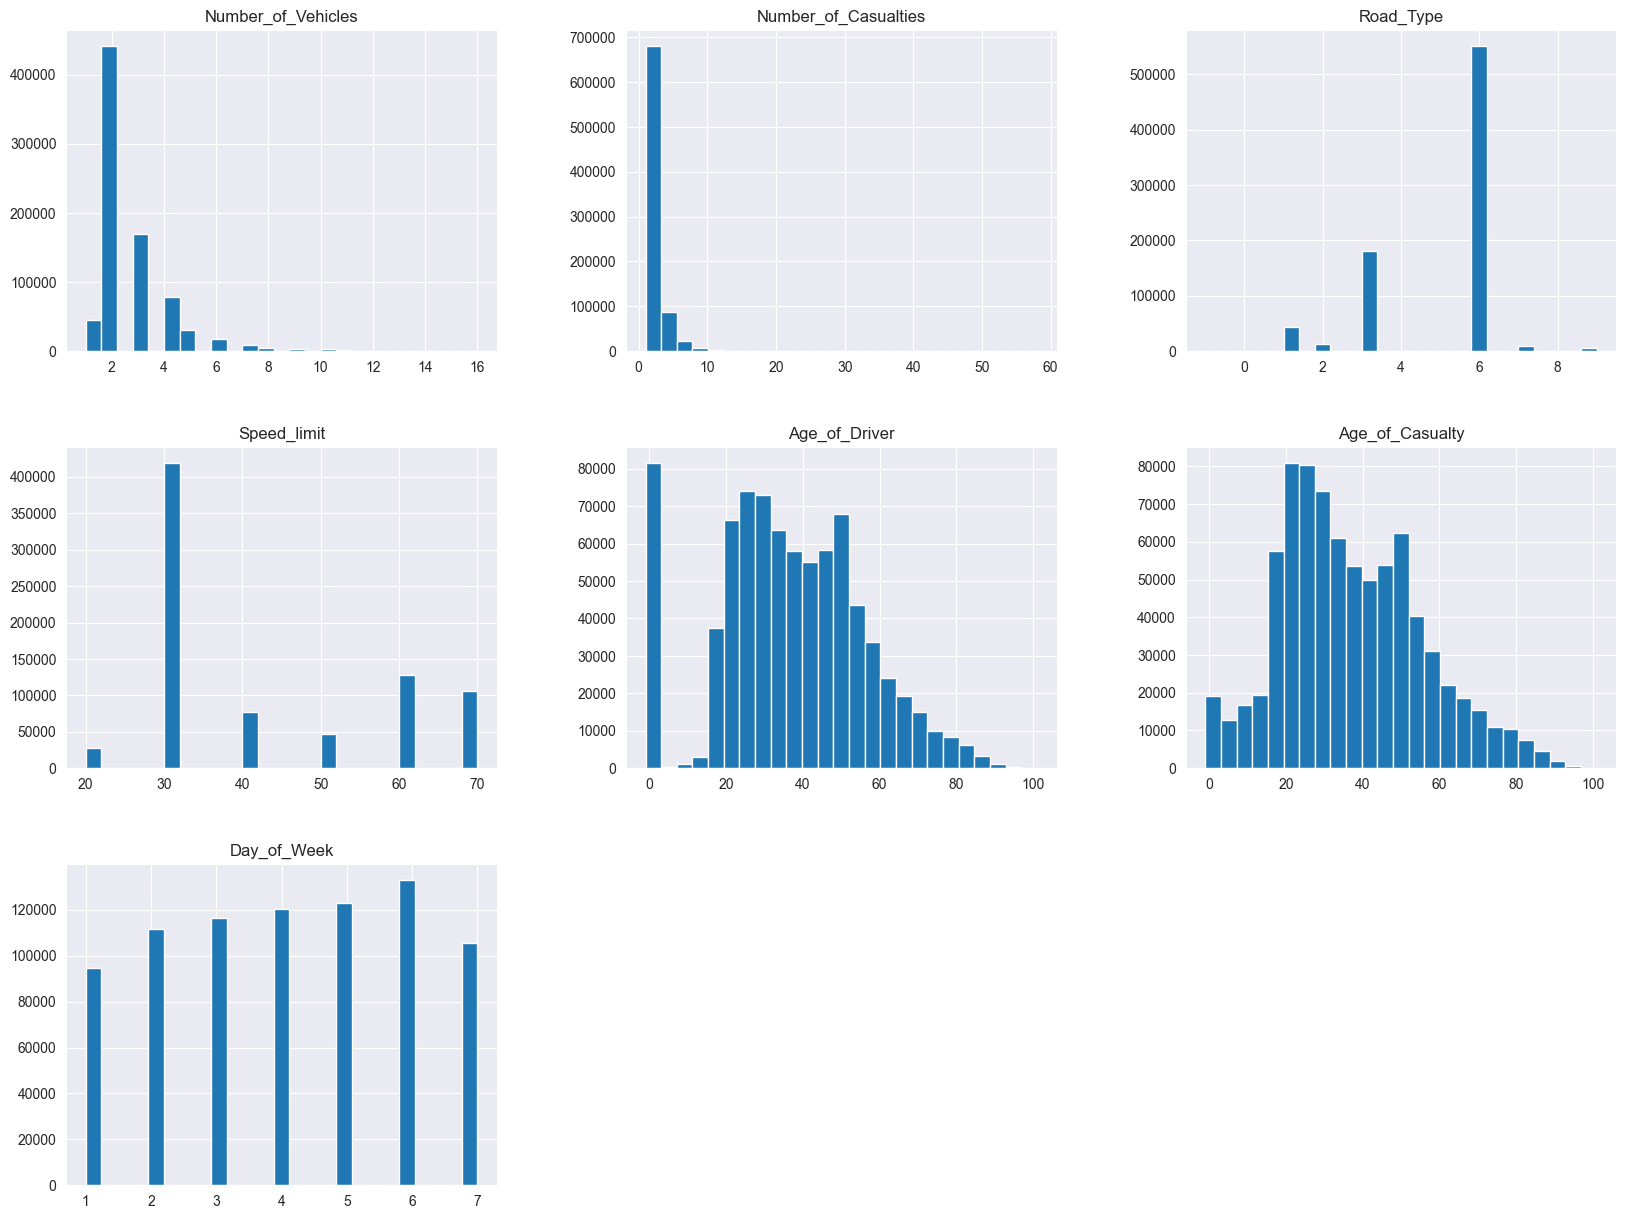

In [39]:
hist_subset = pd.DataFrame(Data_no_geo, columns=['Number_of_Vehicles', 'Number_of_Casualties', 'Road_Type', 'Speed_limit', 'Age_of_Driver', 'Age_of_Casualty', 'Day_of_Week'])
hist = hist_subset.hist(bins=25, figsize=(20,15))


Jak widać z powyższych wyreksów, większość wypadków drogowych w Wielkiej Brytanii odbywa się przy ograniczeniu prędkości do 30 mil na godzinę. Najwięcej wypadków drogowych ma miejsce w sobotę i piątek, a najmniej w poniedziałek. Największy odsetek kierowców powodujących wypadki to osoby w wieku 25-35 lat, choć dla ponad 10% wypadków wiek kierowcy nie jest znany. Analogicznie, najwięcej ofiar wypadków to osoby w wieku 25-35 lat. Można też wyczytać, że na większość wypadków drogowych przypada do 1 lub 2 pojazdy, a liczba ofiar wypadków zazwyczaj nie przekracza 5. Dodatkowo, najwięcej kolizji na drodze ma miejsce na drogach dwukierunkowych, jednopasmowych.

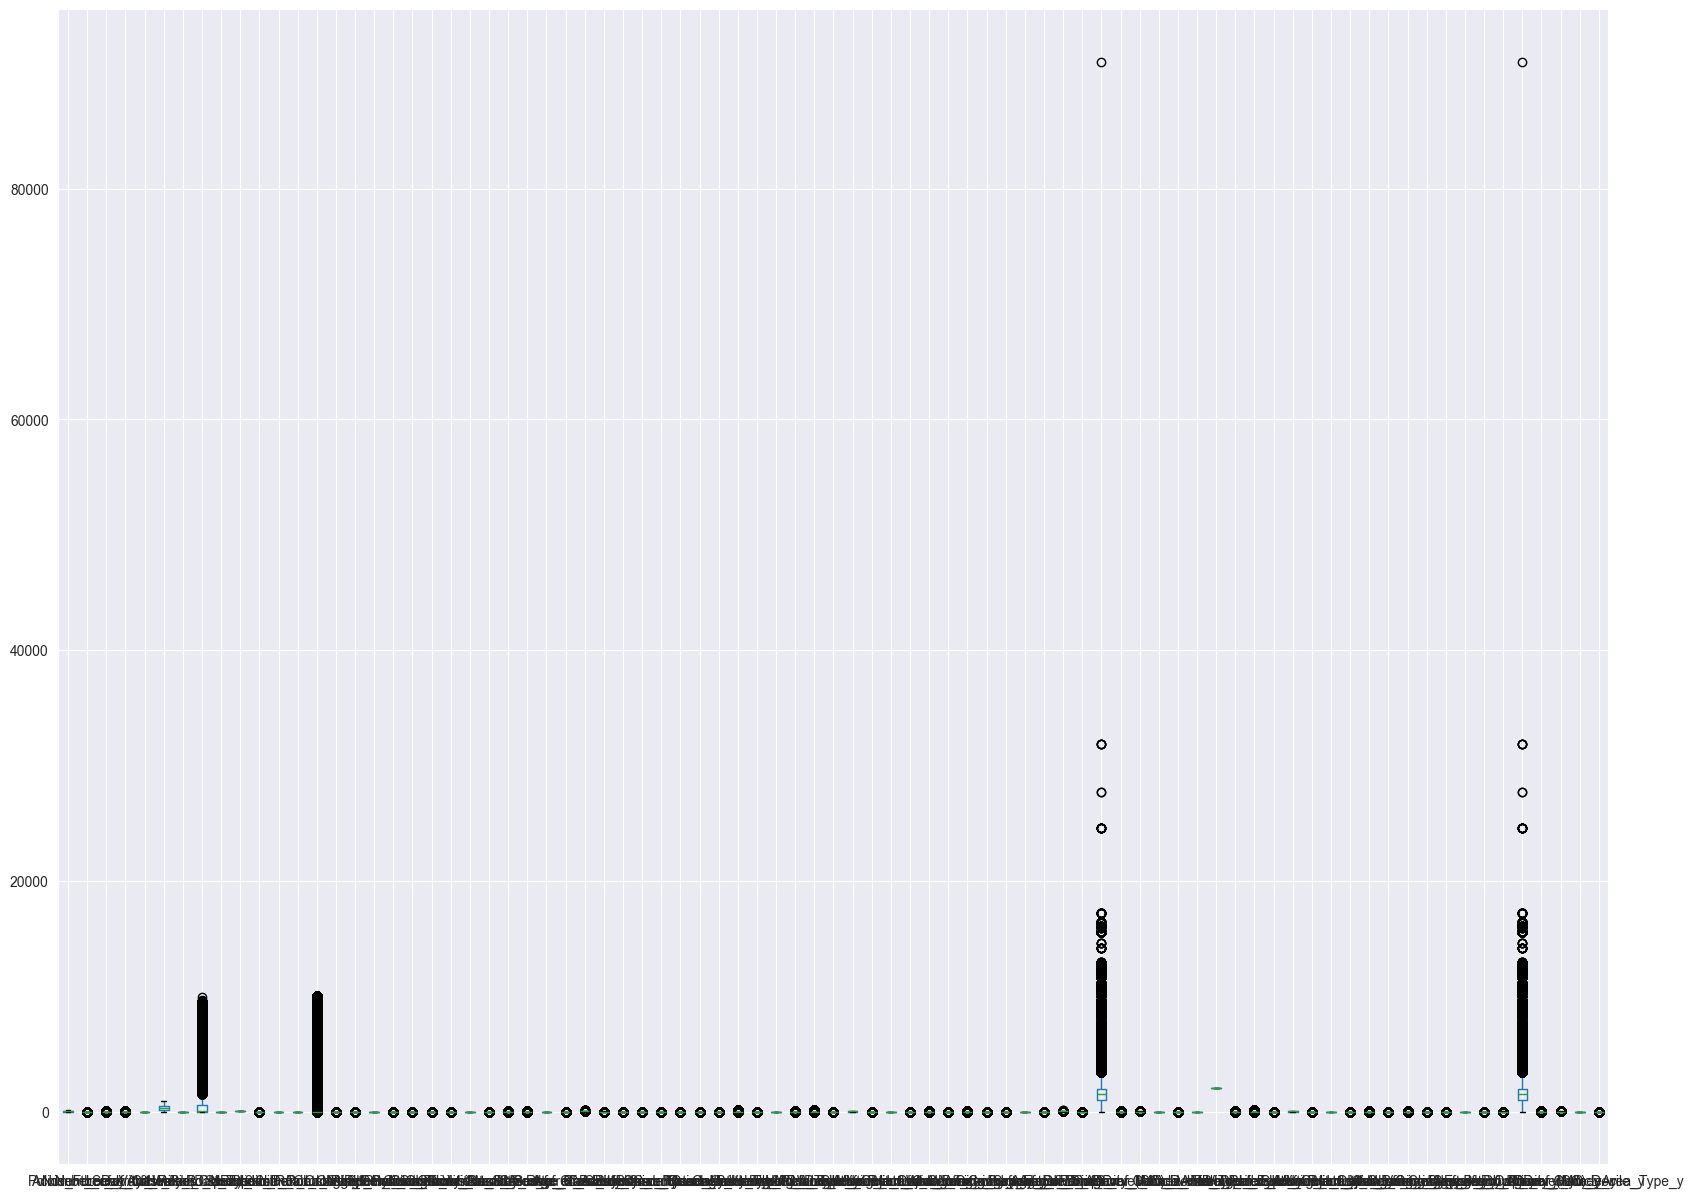

In [12]:
box = Data_no_geo.boxplot(figsize=(20,15))


### Wykresy typu Boxplot

<Axes: >

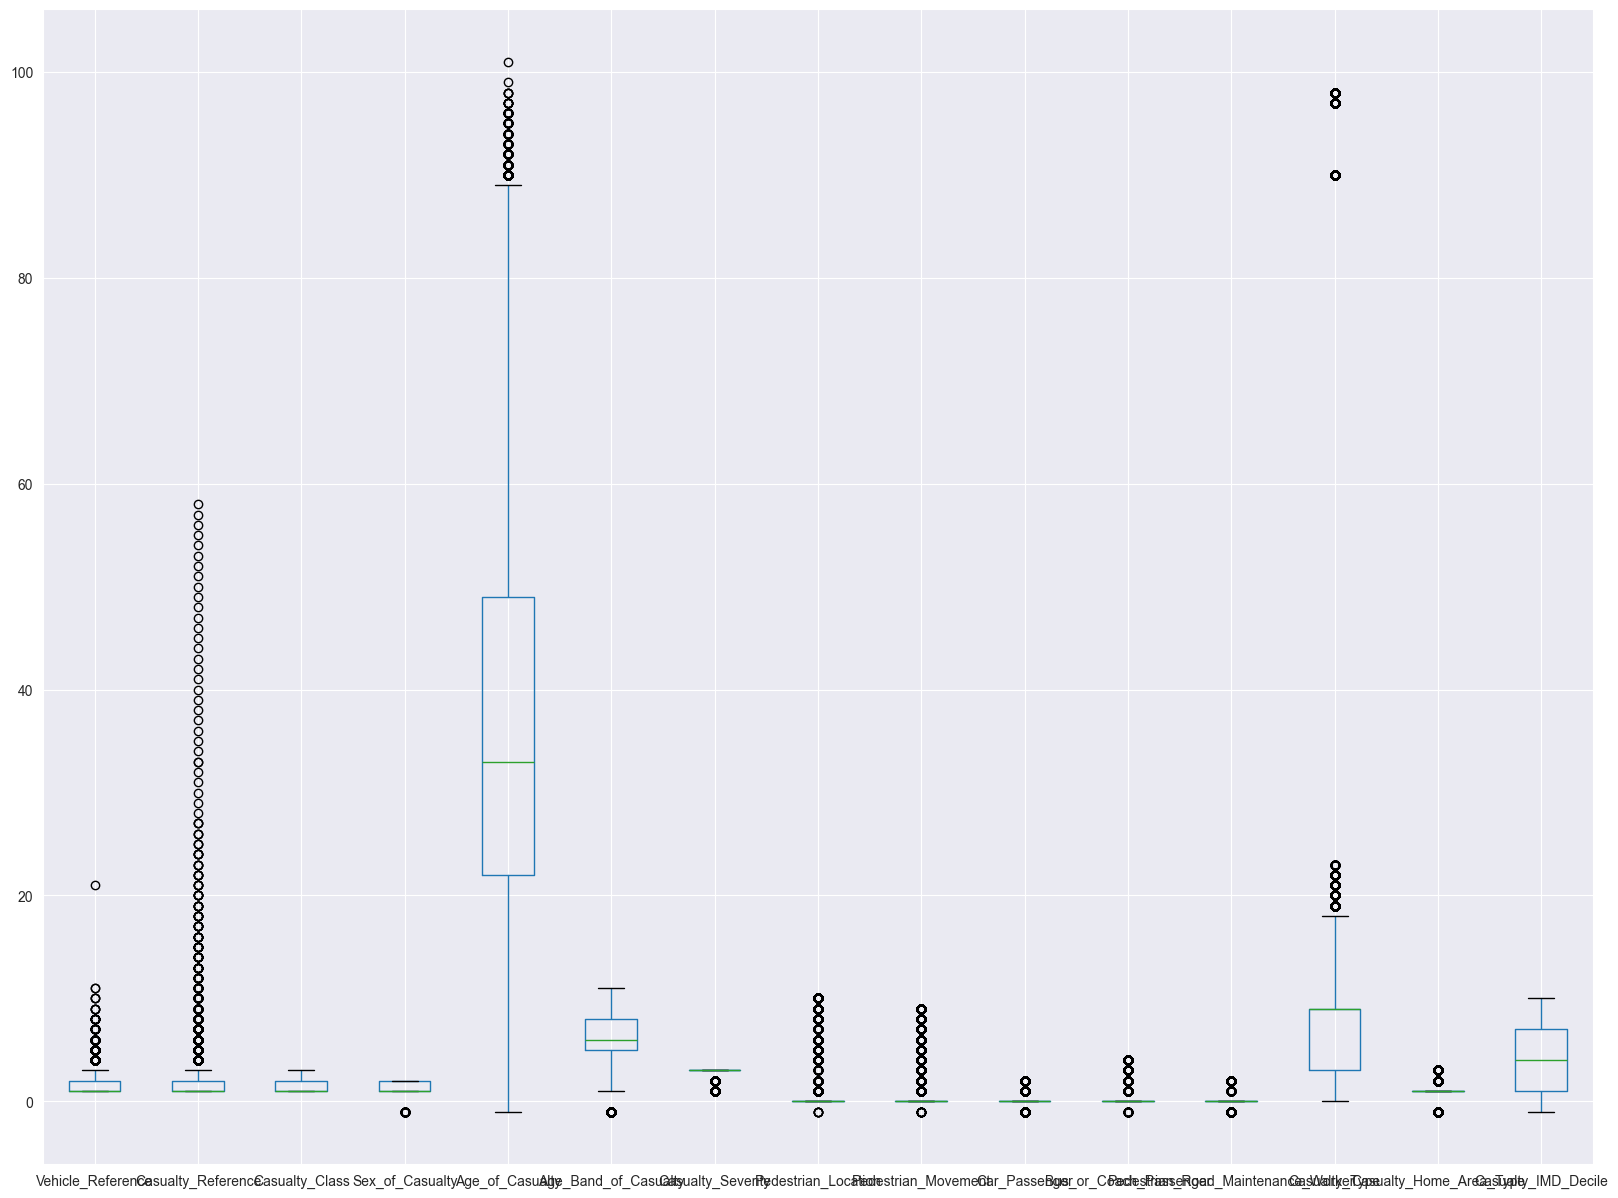

In [14]:
Casualties.boxplot(figsize=(20,15))

<Axes: >

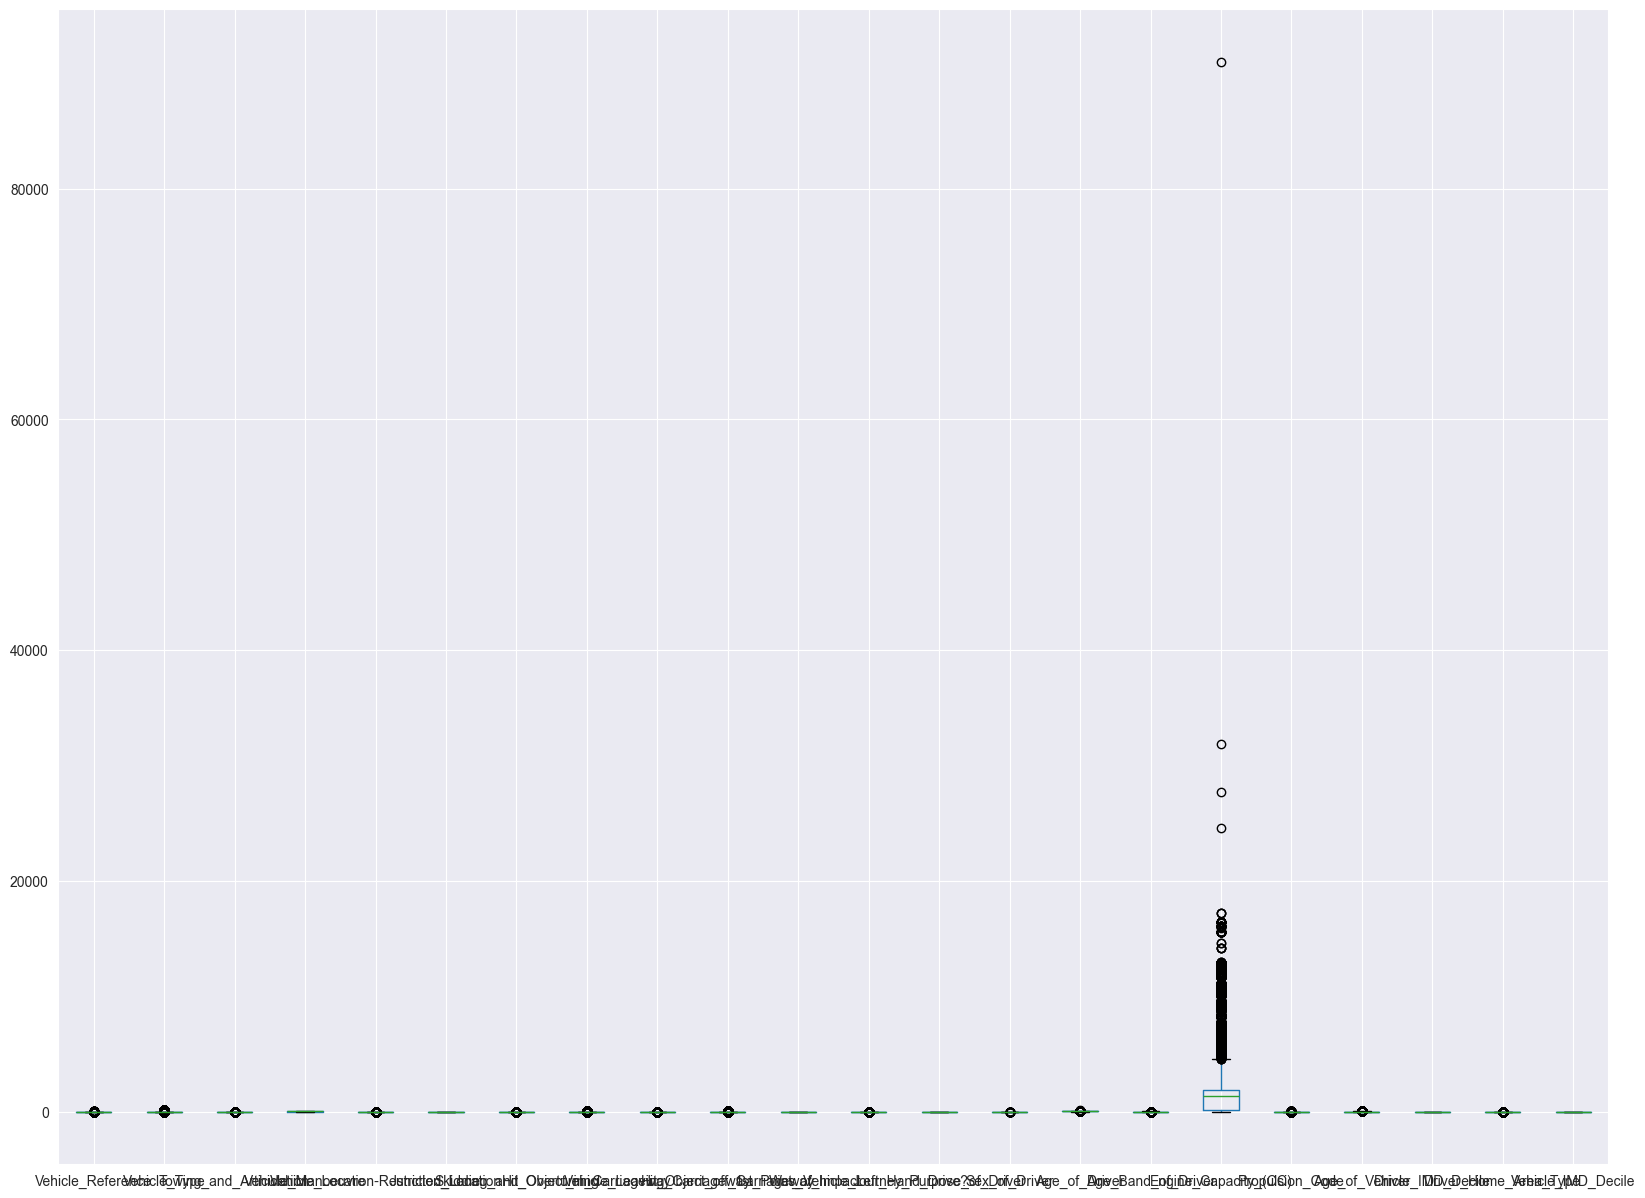

In [15]:
Vehicles.boxplot(figsize=(20,15))

<Axes: >

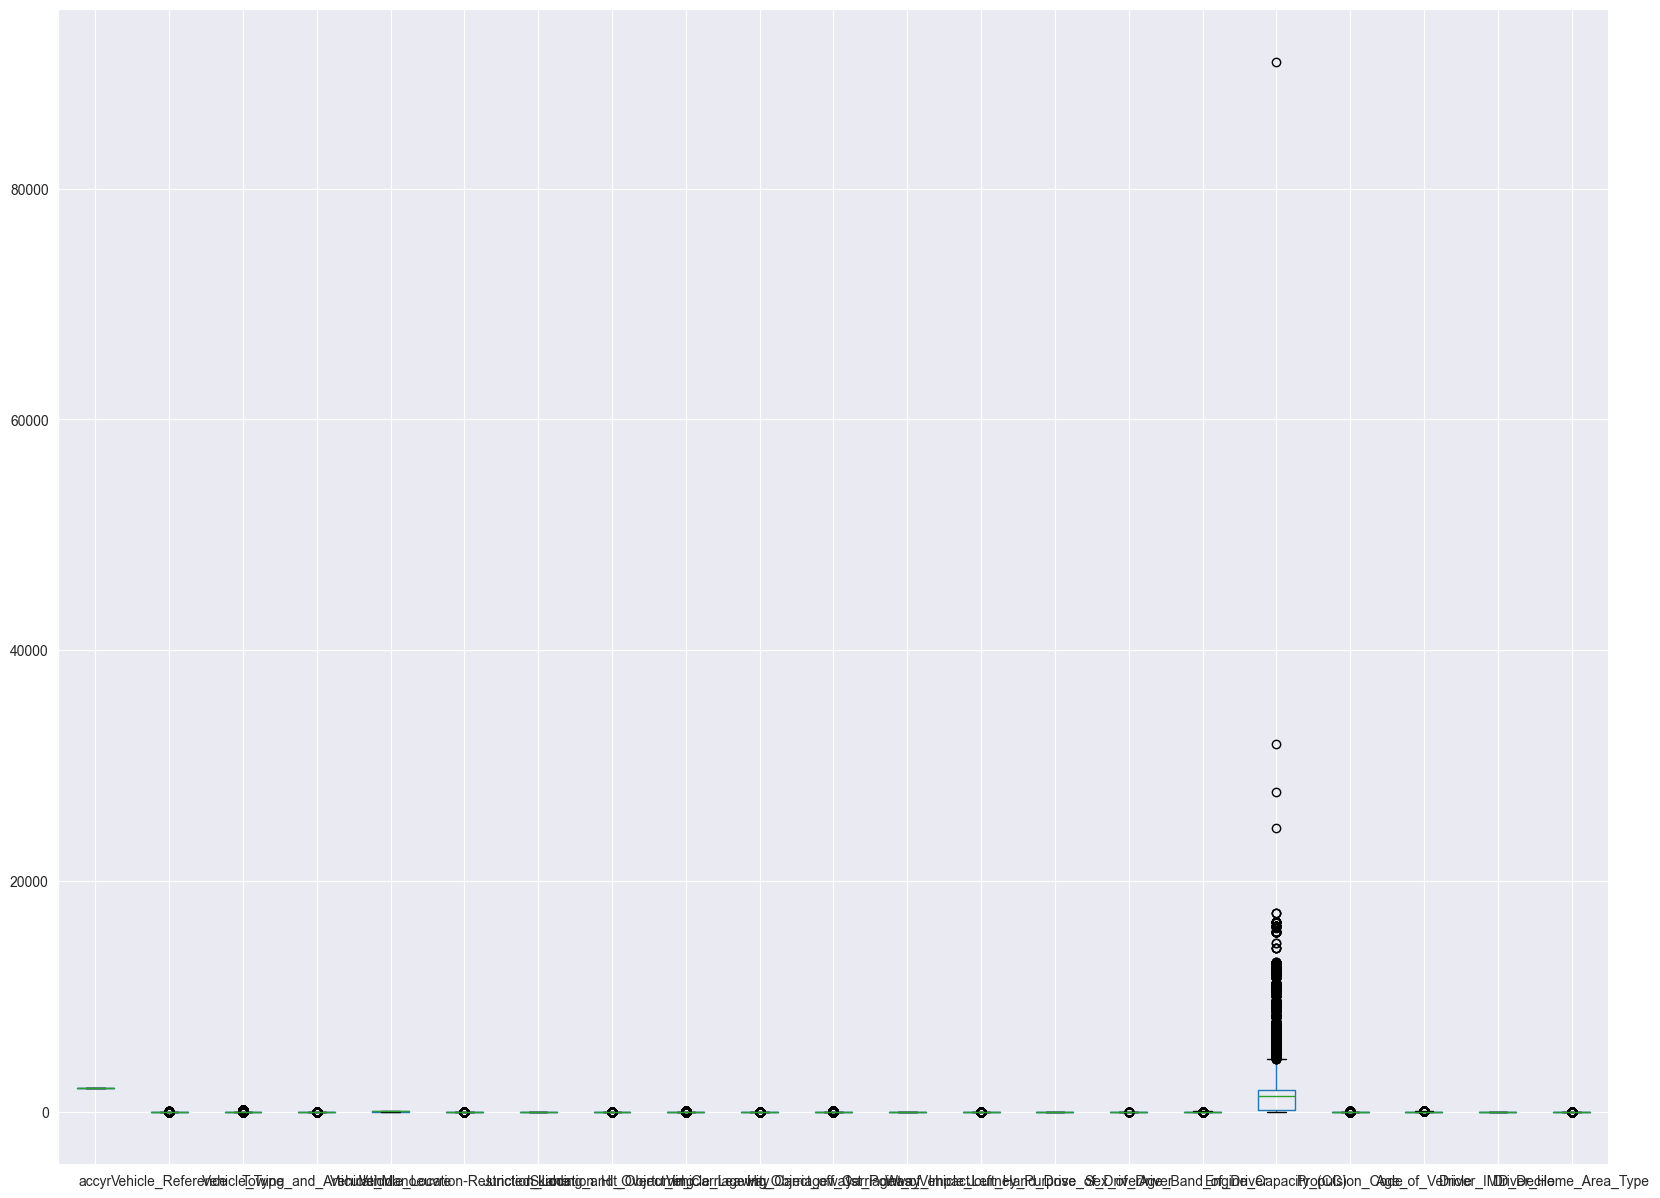

In [16]:
MakeModel.boxplot(figsize=(20,15))

<Axes: >

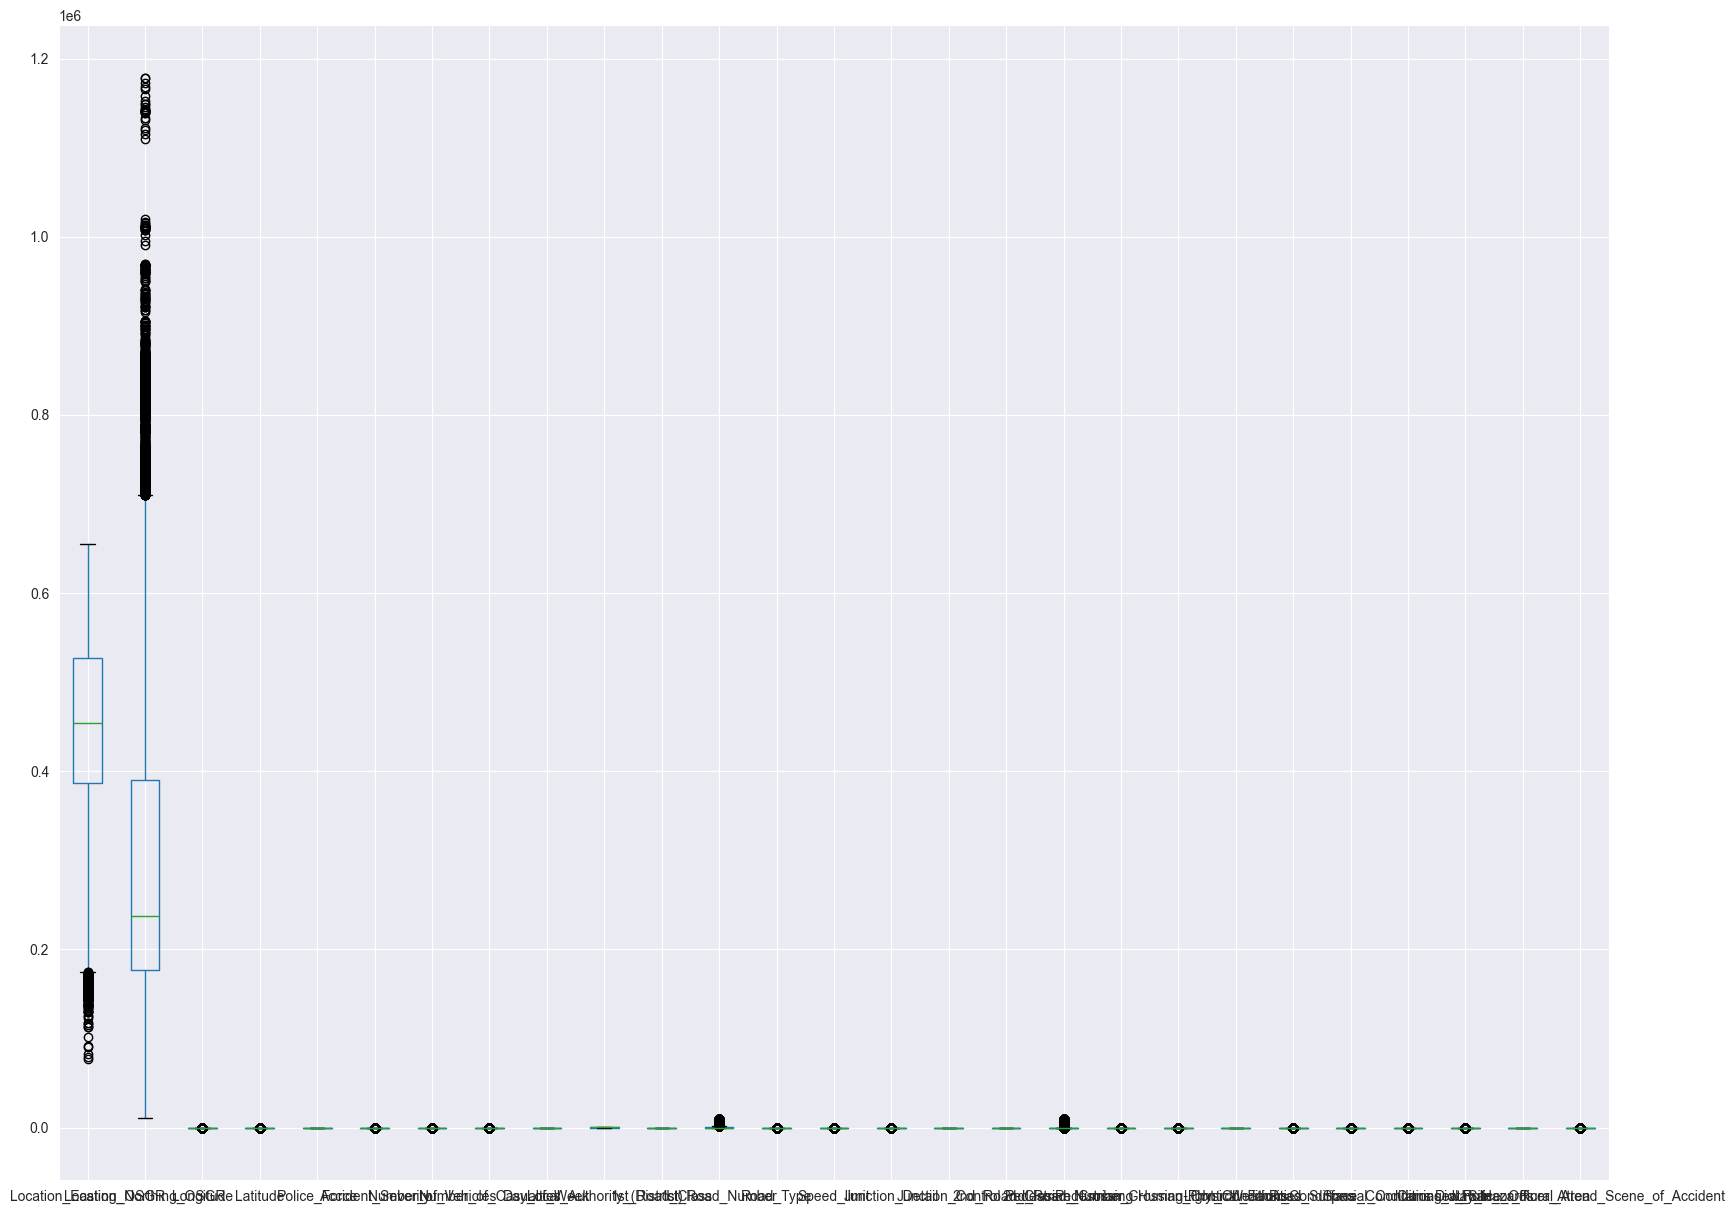

In [17]:
Accidents.boxplot(figsize=(20,15))

### Wykresy dotyczące groźności wypadków

<Axes: xlabel='Accident_Severity', ylabel='Number_of_Casualties'>

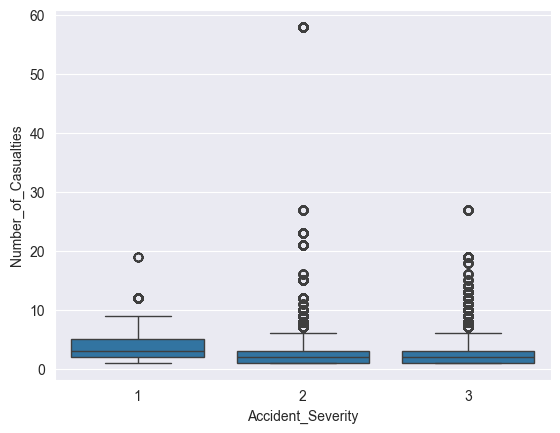

In [18]:
sns.boxplot(x='Accident_Severity', y='Number_of_Casualties', data=Comp_data)

<Axes: xlabel='Accident_Severity', ylabel='count'>

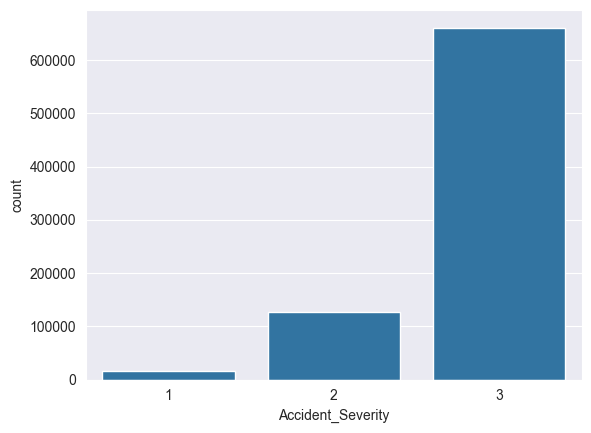

In [19]:
countplt = sns.countplot(x='Accident_Severity', data=Comp_data)
countplt

### Wyodrębnienie kolumny dotyczącej powodu podróży kierowcy

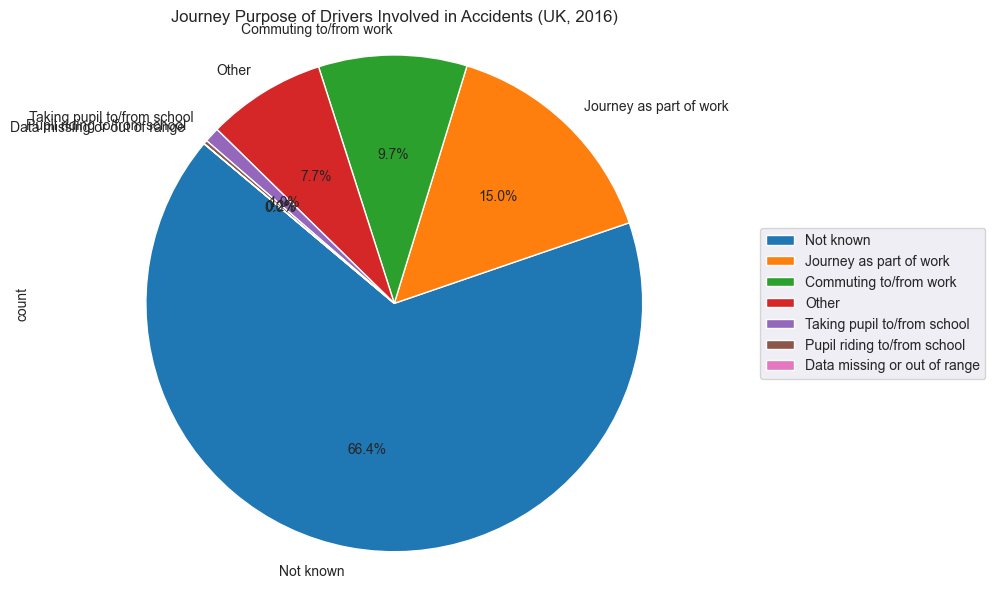

In [20]:
journey_purpose_counts = Comp_data['Journey_Purpose_of_Driver_y'].value_counts()

# Tworzenie opisów do legendy
journey_purpose_legend = {
    1: 'Journey as part of work',
    2: 'Commuting to/from work',
    3: 'Taking pupil to/from school',
    4: 'Pupil riding to/from school',
    5: 'Other',
    6: 'Not known',
    -1: 'Data missing or out of range'
}

# Podstawienie opisów do wartości
journey_purpose_counts.index = journey_purpose_counts.index.map(journey_purpose_legend)

# Tworzenie wykresu kołowego
plt.figure(figsize=(10, 6))
journey_purpose_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Journey Purpose of Drivers Involved in Accidents (UK, 2016)')
plt.axis('equal')  # Ustawienie równych proporcji dla osi x i y



# Przeniesienie legendy poza wykres
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Dostosowanie układu w celu uniknięcia nakładania się elementów
plt.show()

### Mapa wypadków drogowych w Wielkiej Brytanii

In [21]:
# Utworzenie wykresu mapy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-8, 2, 49.5, 60], crs=ccrs.PlateCarree())  # Ustawienie granic na Wielką Brytanię

# Dodanie warstwy granic kraju na różowo
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=1.5, edgecolor='pink')

ax.stock_img()

# Dodanie punktów reprezentujących wypadki drogowe
ax.scatter(Comp_data['Longitude'], Comp_data['Latitude'], transform=ccrs.PlateCarree(), color='red', alpha=0.5, s=10)

plt.title('Mapa wypadków drogowych w Wielkiej Brytanii')
plt.show()

NameError: name 'ccrs' is not defined

<Figure size 1000x800 with 0 Axes>

### Wykres wypadków drogowych według marek samochodów

In [ ]:
# Analiza liczby wypadków według marki pojazdu
wypadki_marka_auta = Comp_data.groupby('make')['Accident_Index'].count().sort_values(ascending=False)

# Wyświetlenie wyników
print("Liczba wypadków według marki auta:")
print(wypadki_marka_auta)

# Tworzenie wykresu słupkowego
plt.figure(figsize=(12, 6))
wypadki_marka_auta.head(10).plot(kind='bar', color='skyblue')
plt.title('Liczba wypadków według marki auta (Top 10)')
plt.xlabel('Marka auta')
plt.ylabel('Liczba wypadków')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Wykres kołowy wypadków drogowych według płci 

In [ ]:
# Tworzenie opisów do legendy
wypadki_plec_legend = {
    1: 'Mężczyzna',
    2: 'Kobieta',
    3: 'Nieznana',
    -1: 'Brak danych'
}

# Analiza wypadków według płci
wypadki_wedlug_plci = Comp_data.groupby('Sex_of_Driver_y')['Accident_Index'].count()

# Podstawienie opisów do wartości
wypadki_wedlug_plci.index = wypadki_wedlug_plci.index.map(wypadki_plec_legend)

# Wyświetlenie wyników
print("Liczba wypadków według płci:")
print(wypadki_wedlug_plci)

# Wykres kołowy przedstawiający udział wypadków według płci
plt.figure(figsize=(8, 6))
plt.pie(wypadki_wedlug_plci, labels=wypadki_wedlug_plci.index, autopct='%1.1f%%', startangle=140)
plt.title('Udział wypadków drogowych według płci')
plt.axis('equal')  # Zapewnia, że koło będzie wyglądać jak koło, a nie jak owal
plt.show()

### Wykres słupkowy wypadków drogowych według wieku kierowców

In [ ]:
# Analiza wieku kierowców
analiza_wieku = Comp_data['Age_Band_of_Driver_y'].value_counts().sort_index()

etykiety = {
    '1': '0-5',
    '2': '6-10',
    '3': '11-15',
    '4': '16-20',
    '5': '21-25',
    '6': '26-35',
    '7': '36-45',
    '8': '46-55',
    '9': '56-65',
    '10': '66-75',
    '11': 'Over 75',
    '-1': 'Data missing'
}


# Tworzenie wykresu słupkowego z etykietami
plt.figure(figsize=(10, 6))
analiza_wieku.plot(kind='bar', color='skyblue')
plt.title('Analiza wieku kierowców')
plt.xlabel('Grupa wiekowa')
plt.ylabel('Liczba wypadków')
plt.xticks(rotation=45)
plt.xticks(analiza_wieku.index, [etykiety.get(str(x), 'Unknown') for x in analiza_wieku.index])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Pairplot z wybranymi danymi

In [ ]:
data_to_plot = Comp_data[['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']]

# Przeprowadzenie analizy pairplotów
sns.pairplot(data_to_plot)
plt.show()